In [1]:
# Name: Ali Khatami
# Course: DSC530-T301
# Final Project: AirBNB price analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import scipy.stats as stats
from scipy.stats import norm, expon, lognorm, pareto
import thinkplot
import thinkstats2
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
"""
1.  Your dataset
"""

'\n1.  Your dataset\n'

In [4]:
# Read all the csv files in the folder
data_list = glob.glob('Airbnb Prices in Europe/*.csv')

# Now we can use pandas to read all the csv files and combine them into one
df = pd.concat(map(pd.read_csv, data_list))

# Cross-Featuring the longitude and latitude
df['lng-lat'] = df['lng'] * df['lat'] / 1000000

# Drop the index column
df.drop(['Unnamed: 0', 'rest_index_norm', 'attr_index_norm', 'room_private', 'room_shared', 'lng', 'lat'], axis=1, inplace=True)

# Check if there are any null values
df.isnull().sum()

realSum                       0
room_type                     0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
rest_index                    0
lng-lat                       0
dtype: int64

In [5]:
"""
2.  A minimum of 5 variables in your dataset used during your analysis
"""

'\n2.  A minimum of 5 variables in your dataset used during your analysis\n'

In [6]:
# Getting the first 5 rows of the data
df.head()

,realSum,room_type,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,lng-lat
0,194.033698,Private room,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,98.253896,0.000257
1,344.245776,Private room,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,837.280757,0.000257
2,264.101422,Private room,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,95.386955,0.000261
3,433.529398,Private room,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,875.033098,0.000256
4,485.552926,Private room,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,815.305740,0.000257


In [7]:
# Transforming room_type to a dummy variable
df = pd.get_dummies(df, columns=['room_type', 'host_is_superhost'], drop_first=True)

In [8]:
"""
3.  Include a histogram of each of the 5 variables
"""

'\n3.  Include a histogram of each of the 5 variables\n'

In [9]:
# Changing the column names
df.rename(columns={
    'realSum': 'price', 'person_capacity': 'capacity', 'multi': '2_4_listings_host', 'biz': '4_plus_listings host', 'guest_satisfaction_overall': 'satisfaction_rating', 'dist': 'city_dist', 'attr_index': 'attractions_rating', 'rest_index': 'restaurants_rating'}, inplace=True)

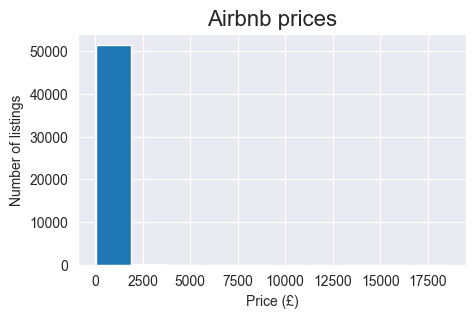

In [10]:
# Visualize the distribution of the prices
plt.figure(figsize=(5, 3))
df.price.hist()
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.title("Airbnb prices", fontsize=16)
plt.show()

In [11]:
# Calculate the statistics of the prices
df.price.describe()

count    51707.000000
mean       279.879591
std        327.948386
min         34.779339
25%        148.752174
50%        211.343089
75%        319.694287
max      18545.450285
Name: price, dtype: float64

In [12]:
# Calculate the distribution of the prices
bins = [0, 50, 100, 150, 200, 350, 500, 1000, 1500, 2500, 3000, 3500, int(df.price.max())]
bin_counts = pd.cut(df.price, bins).value_counts()
bin_percentages = bin_counts / df.shape[0] * 100
hist_df = pd.DataFrame({'range': bin_percentages.index, '%': bin_percentages.values})
hist_df = hist_df.sort_values('range').reset_index(drop=True)
hist_df

,range,%
0,"(0, 50]",0.096699
1,"(50, 100]",5.883149
2,"(100, 150]",19.589224
3,"(150, 200]",20.521399
4,"(200, 350]",32.889164
5,"(350, 500]",10.990775
6,"(500, 1000]",8.538496
7,"(1000, 1500]",0.992129
8,"(1500, 2500]",0.348115
9,"(2500, 3000]",0.048349


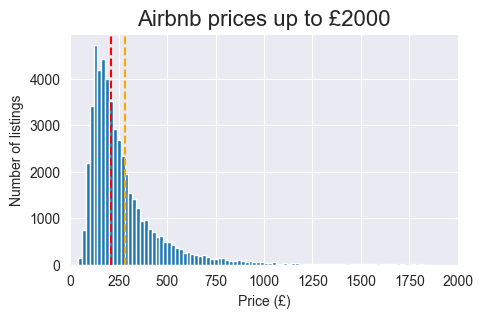

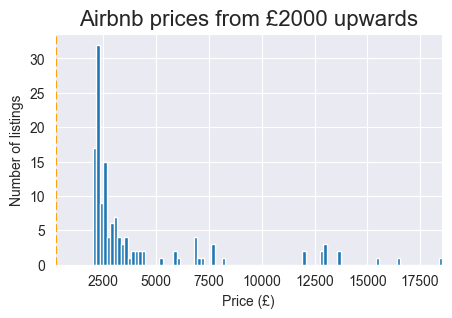

In [13]:
# Visualize the distribution of the prices up to £1500
plt.figure(figsize=(5, 3))
df.price.hist(bins=100, range=(0, 2000))
plt.margins(x=0)
plt.axvline(df.price.mean(), color='orange', linestyle='--')
plt.axvline(df.price.median(), color='red', linestyle='--')
plt.title("Airbnb prices up to £2000", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

# Visualize the distribution of the prices from £2000 upwards
plt.figure(figsize=(5, 3))
df.price.hist(bins=100, range=(2000, max(df.price)))
plt.margins(x=0)
plt.axvline(df.price.mean(), color='orange', linestyle='--')
plt.axvline(df.price.median(), color='red', linestyle='--')
plt.title("Airbnb prices from £2000 upwards", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

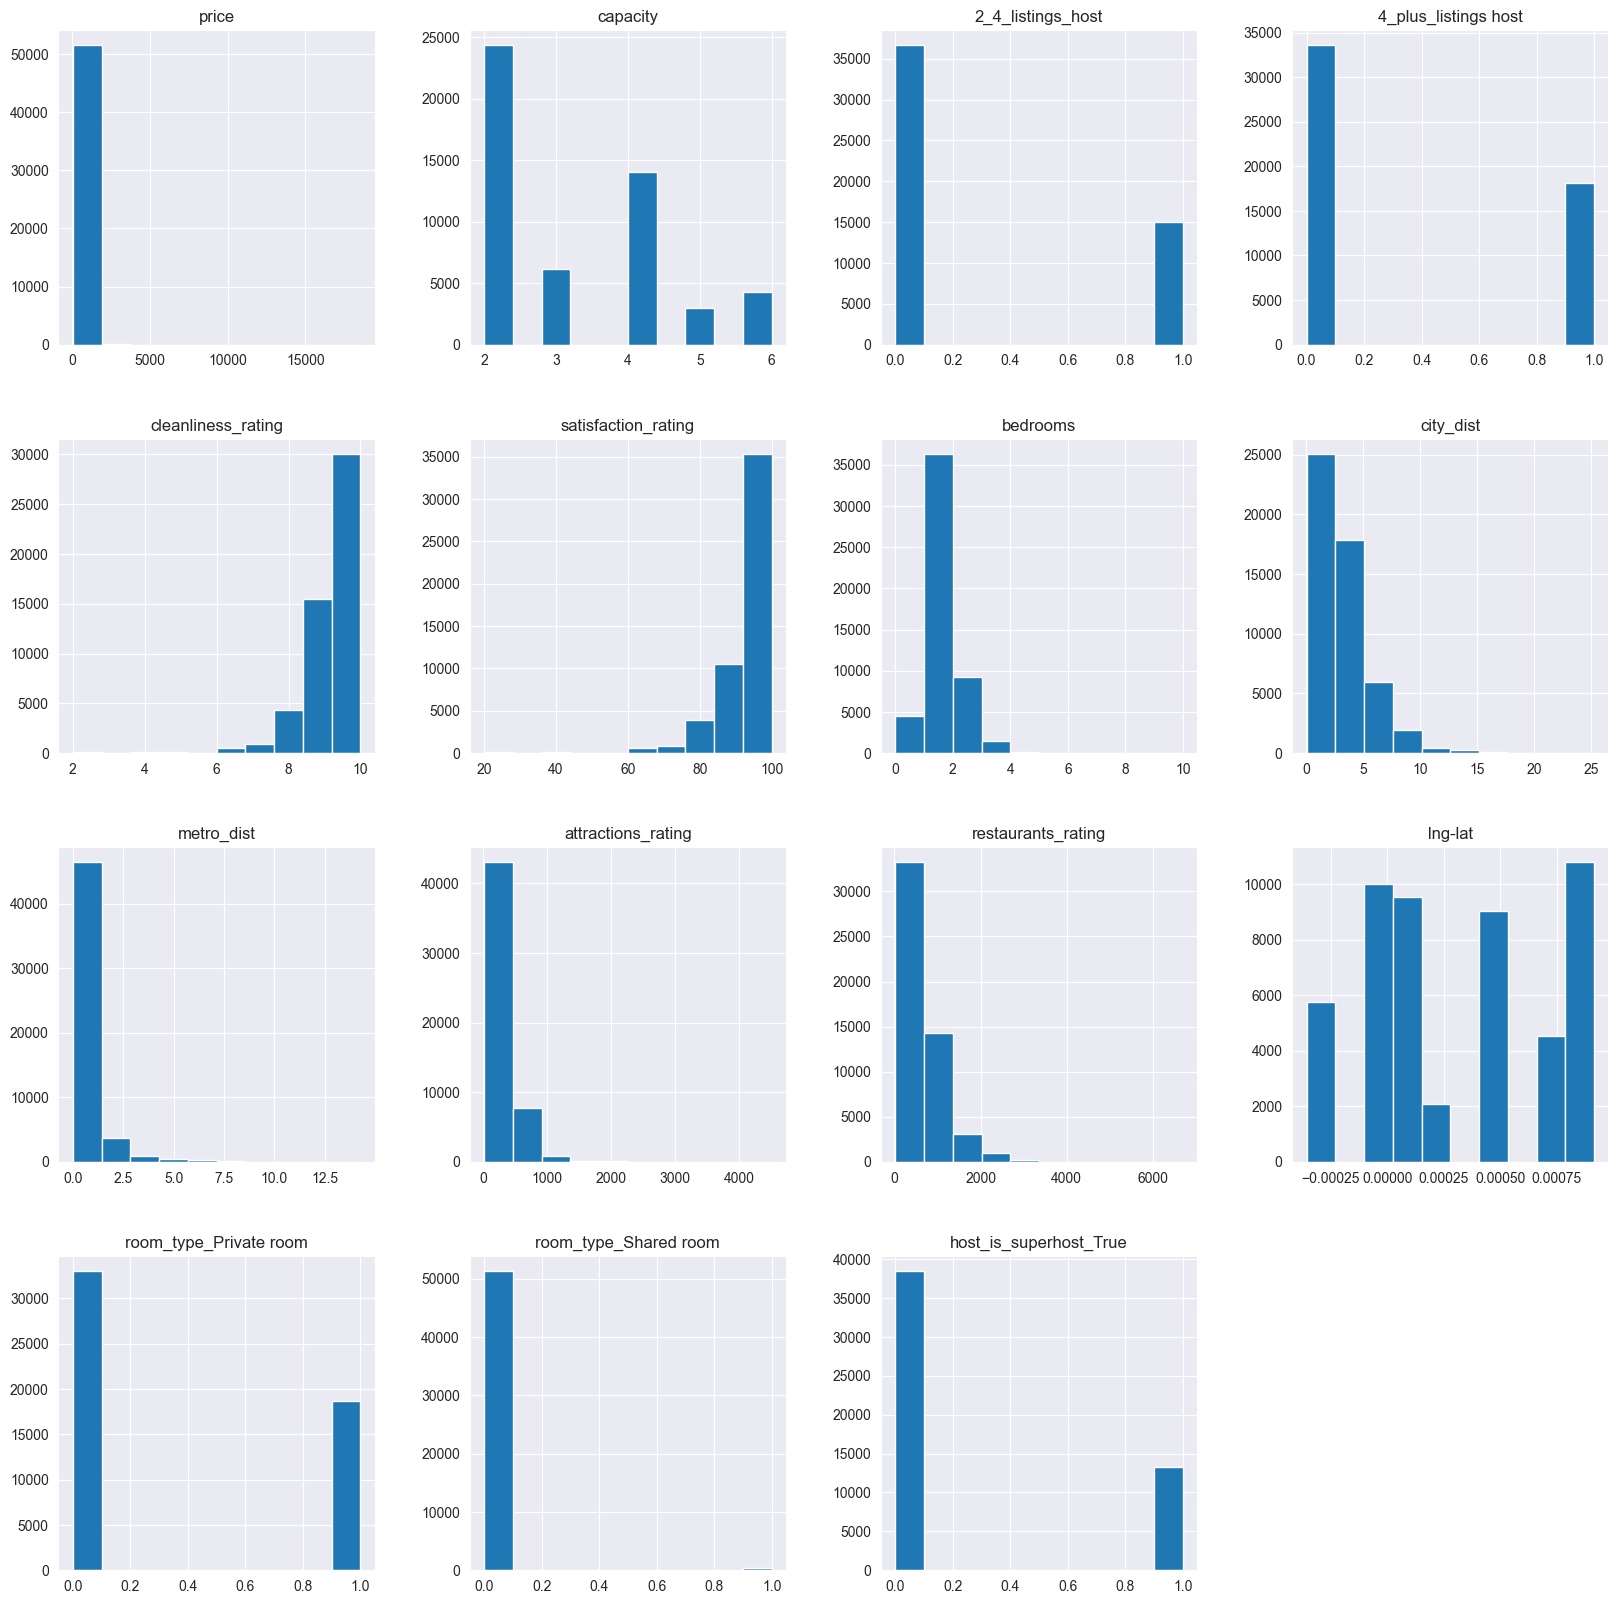

In [14]:
# plotting the data distributions
df.hist(figsize=(20, 20))
plt.show()

In [15]:
# Calculating the correlation matrix and round to 4 decimals
df.corr().round(4)

,price,capacity,2_4_listings_host,4_plus_listings host,cleanliness_rating,satisfaction_rating,bedrooms,city_dist,metro_dist,attractions_rating,restaurants_rating,lng-lat,room_type_Private room,room_type_Shared room,host_is_superhost_True
price,1.0000,0.2031,-0.0529,0.0371,-0.0061,-0.0019,0.2217,-0.0447,-0.0610,0.1782,0.1347,-0.1692,-0.1719,-0.0351,-0.0455
capacity,0.2031,1.0000,-0.0543,0.1107,0.0033,0.0052,0.5606,-0.1285,-0.0373,0.0284,0.0373,0.1391,-0.5000,0.0351,0.0314
2_4_listings_host,-0.0529,-0.0543,1.0000,-0.4707,0.0411,0.0543,-0.0007,0.0334,0.0434,0.0063,0.0071,0.0400,0.1370,-0.0161,0.0975
4_plus_listings host,0.0371,0.1107,-0.4707,1.0000,-0.1073,-0.2082,-0.0267,-0.1648,-0.1092,0.1147,0.1377,-0.0963,-0.0402,0.0444,-0.1085
cleanliness_rating,-0.0061,0.0033,0.0411,-0.1073,1.0000,0.7140,0.0335,-0.0302,0.0104,-0.0253,-0.0319,0.1181,-0.0310,-0.0401,0.2724
satisfaction_rating,-0.0019,0.0052,0.0543,-0.2082,0.7140,1.0000,0.0476,-0.0042,0.0298,-0.0506,-0.0693,0.1585,-0.0334,-0.0279,0.2801
bedrooms,0.2217,0.5606,-0.0007,-0.0267,0.0335,0.0476,1.0000,-0.0063,0.0444,-0.0117,-0.0140,0.0049,-0.1559,-0.0214,0.0242
city_dist,-0.0447,-0.1285,0.0334,-0.1648,-0.0302,-0.0042,-0.0063,1.0000,0.5581,-0.3631,-0.3467,-0.1362,0.2134,0.0141,-0.0561
metro_dist,-0.0610,-0.0373,0.0434,-0.1092,0.0104,0.0298,0.0444,0.5581,1.0000,-0.1680,-0.1389,-0.0670,0.1020,-0.0029,-0.0007
attractions_rating,0.1782,0.0284,0.0063,0.1147,-0.0253,-0.0506,-0.0117,-0.3631,-0.1680,1.0000,0.8502,-0.1472,-0.0223,-0.0315,-0.0263


Generating a heatmap visualization of the correlation matrix for the dataset using Seaborn and Matplotlib libraries. The first few lines set the style of the visualization to a white background. The correlation matrix is computed from the data and a mask is generated to hide the upper triangle of the matrix. Then, a custom colormap is generated and a heatmap is drawn using Seaborn. The resulting heatmap shows the correlations between the variables in the dataset, where red indicates positive correlation and blue indicates negative correlation.

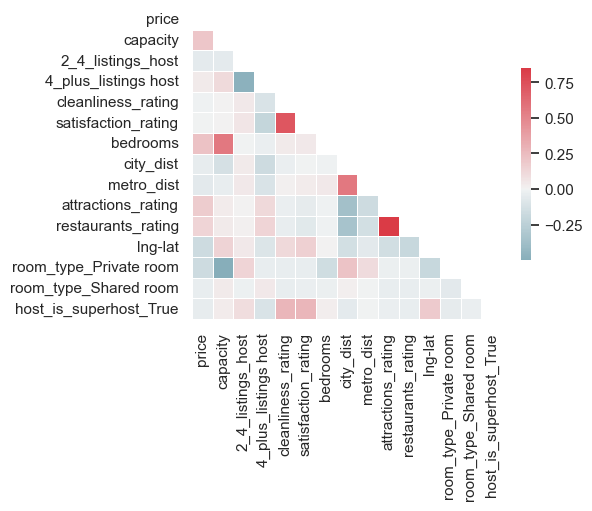

In [16]:
# Set the style of the visualization
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the multi-collinear heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

Highly correlated variables in a dataset can cause issues in statistical analysis. When two variables are highly correlated, they contain redundant information, which can skew the results of analysis or models. Hence we remove them.

In [17]:
# Removing highly correlated variables
df.drop(['restaurants_rating', 'capacity', 'metro_dist'], axis=1, inplace=True)

The purpose of this code is to visualize the distribution of the logarithmically transformed numerical variables to better understand where the median and mean fall and how the outliers are distributed. The logarithmic transformation is used to normalize the data and reduce the skewness of the distribution.

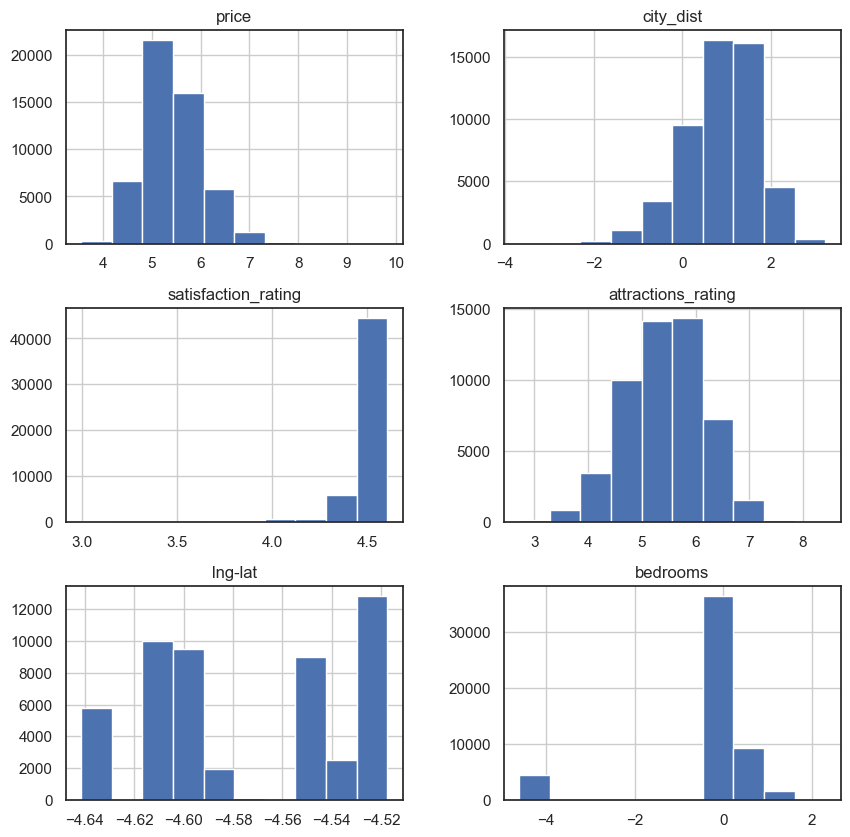

In [18]:
# Setting numerical variables
num_vars = ['price', 'city_dist', 'satisfaction_rating', 'attractions_rating', 'lng-lat', 'bedrooms']

# Logarithmic transformation of the numerical variables
num_log = np.log(df[num_vars] + 0.01)

# Plotting the log transformation of all numerical variables
num_log.hist(figsize=(10, 10))
plt.show()

In [19]:
"""
4.  Identify any outliers and explain the reasoning for them being outliers
"""

'\n4.  Identify any outliers and explain the reasoning for them being outliers\n'

This code is used to identify outliers in the 'price' variable of a dataframe df using the z-score method and the threshold of 3 standard deviations away from the mean. Based on the results, we see price values over 1263 have been assigned as outliers as they are 3 standard deviations away from the mean.

In [20]:
price_outliers = df[abs(stats.zscore(df['price'])) > 3]
print(f"Minimum outlier price: {price_outliers['price'].min()}")
price_outliers

Minimum outlier price: 1263.905548107905


,price,2_4_listings_host,4_plus_listings host,cleanliness_rating,satisfaction_rating,bedrooms,city_dist,attractions_rating,lng-lat,room_type_Private room,room_type_Shared room,host_is_superhost_True
7,2771.307384,0,0,10.0,100.0,3,1.686807,208.808109,0.000256,0,0,1
35,1609.917278,1,0,10.0,96.0,3,2.988589,207.952474,0.000255,0,0,0
92,1557.190730,0,0,9.0,98.0,2,0.750395,834.247624,0.000256,0,0,1
99,3004.944579,0,0,9.0,95.0,4,1.615295,216.669036,0.000256,0,0,0
102,1376.514424,0,1,10.0,93.0,2,1.930702,185.070219,0.000256,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5079,1707.707143,0,1,10.0,100.0,2,4.699539,294.436286,-0.000010,0,0,0
5133,1371.386909,0,1,10.0,100.0,2,4.521703,314.573633,-0.000010,0,0,1
5220,1588.701522,0,1,10.0,100.0,1,5.218509,265.004213,-0.000003,1,0,0
5337,1375.385122,0,1,7.0,72.0,3,1.767394,513.175078,-0.000008,0,0,0


In [21]:
"""
5.  How you believe they should be handled
6.  Include the other descriptive characteristics about the variables: Mean, Mode, Spread, and Tails
"""

'\n5.  How you believe they should be handled\n6.  Include the other descriptive characteristics about the variables: Mean, Mode, Spread, and Tails\n'

The outliers are then removed from the dataframe and we get the new descriptive statistics of the dataframe that shows the mean and standard deviation of all the variables.

In [22]:
# Calculate the z-score for each value in the price column
z_scores = stats.zscore(df['price'])

# remove outliers using the z-score method
df = df.loc[abs(z_scores) < 3, :]

# calculate summary statistics for the updated dataframe
stats = df.describe()

# calculate skewness for each column
skewness = df.skew()
skewness.name = 'skewness'

# add the skewness row to the summary statistics dataframe
summary_stats = stats.append(skewness)

# Add mode to the summary statistics dataframe
summary_stats.loc['mode'] = df.mode().iloc[0]

print(summary_stats)

                 price  2_4_listings_host  4_plus_listings host  \
count     51304.000000       51304.000000          51304.000000   
mean        263.370824           0.291771              0.350441   
std         175.846065           0.454582              0.477113   
min          34.779339           0.000000              0.000000   
25%         148.423439           0.000000              0.000000   
50%         209.553376           0.000000              0.000000   
75%         315.267033           1.000000              1.000000   
max        1263.398266           1.000000              1.000000   
skewness      2.068670           0.916172              0.626960   
mode        184.462161           0.000000              0.000000   

          cleanliness_rating  satisfaction_rating      bedrooms     city_dist  \
count           51304.000000         51304.000000  51304.000000  51304.000000   
mean                9.389463            92.610635      1.150826      3.194854   
std                

/var/folders/71/krwvwqnd59748c6sr2hd_3mh0000gn/T/ipykernel_20027/483165559.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_stats = stats.append(skewness)


In [23]:
"""
7.  Compare two scenarios in your data using a PMF. Reminder, this isn’t comparing two variables against each other – it is the same variable, but a different scenario. Almost like a filter.
"""

'\n7.  Compare two scenarios in your data using a PMF. Reminder, this isn’t comparing two variables against each other – it is the same variable, but a different scenario. Almost like a filter.\n'

/Users/alikhatami/PycharmProjects/dsc530_final_project/thinkstats2.py:161: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
/Users/alikhatami/PycharmProjects/dsc530_final_project/thinkstats2.py:161: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())


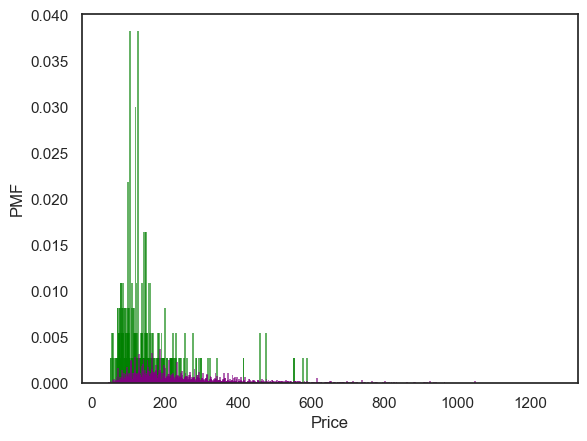

In [24]:
# Create two scenarios to compare using the room type
scenario1 = df[df['room_type_Shared room'] == 1]['price']
scenario2 = df[df['room_type_Shared room'] == 0]['price']

# create PMFs for each scenario
pmf1 = thinkstats2.Pmf(scenario1)
pmf2 = thinkstats2.Pmf(scenario2)

# plot PMFs using bar graphs using the bar function from thinkplot
thinkplot.PrePlot(2)
thinkplot.Hist(pmf1, align='right', width=5, color='green')
thinkplot.Hist(pmf2, align='left', width=5, color='purple')
thinkplot.Config(xlabel='Price', ylabel='PMF')

/Users/alikhatami/PycharmProjects/dsc530_final_project/thinkstats2.py:161: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())
/Users/alikhatami/PycharmProjects/dsc530_final_project/thinkstats2.py:161: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())


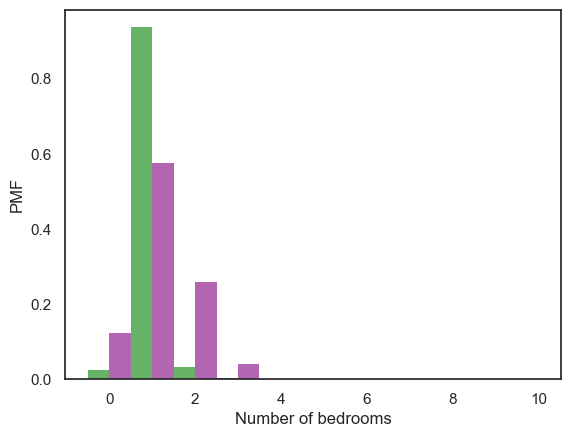

In [25]:
# Create two scenarios to compare using the room type
scenario1 = df[df['room_type_Private room'] == 1]['bedrooms']
scenario2 = df[df['room_type_Private room'] == 0]['bedrooms']

# create PMFs for each scenario
pmf1 = thinkstats2.Pmf(scenario1)
pmf2 = thinkstats2.Pmf(scenario2)

# plot PMFs using bar graphs using the bar function from thinkplot
thinkplot.PrePlot(2)
thinkplot.Hist(pmf1, align='right', width=0.5, color='green')
thinkplot.Hist(pmf2, align='left', width=0.5, color='purple')
thinkplot.Config(xlabel='Number of bedrooms', ylabel='PMF')

In [26]:
"""
8.  Create 1 CDF with one of your variables,
"""

'\n8.  Create 1 CDF with one of your variables,\n'

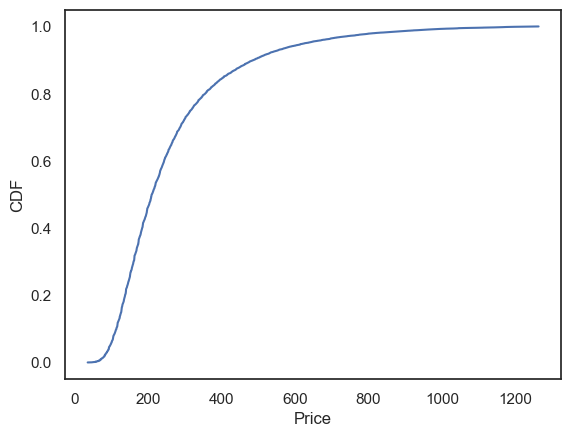

In [27]:
cdf = df['price'].value_counts().sort_index().cumsum()

cdf = cdf / cdf.max()

plt.plot(cdf.index, cdf)
plt.xlabel('Price')
plt.ylabel('CDF')
plt.show()

In [28]:
"""
9.  Plot 1 analytical distribution
"""

'\n9.  Plot 1 analytical distribution\n'

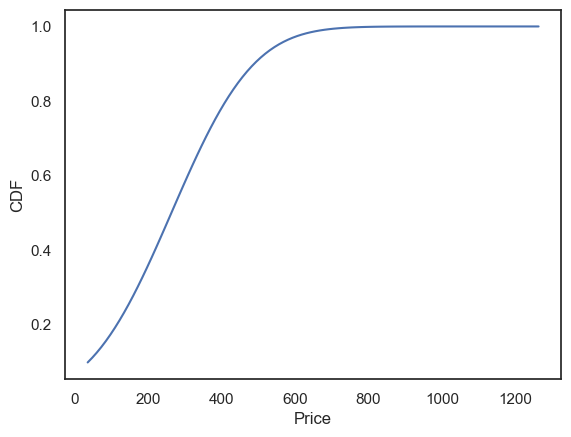

In [29]:
# calculate mean and standard deviation of 'price' column
mu, std = df['price'].mean(), df['price'].std()

# create a normal distribution with the calculated mean and standard deviation
dist = norm(mu, std)

# create an x-axis range for the plot
x = np.linspace(df['price'].min(), df['price'].max(), 100)

# calculate the cdf values for the x range
cdf = dist.cdf(x)

# plot the cdf of the normal distribution
plt.plot(x, cdf)

# set the x and y labels of the plot
plt.xlabel('Price')
plt.ylabel('CDF')

# show the plot
plt.show()

In [30]:
"""
10. Create two scatter plots comparing two variables and provide your analysis on correlation and causation. Remember, covariance, Pearson’s correlation, and Non-Linear Relationships should also be considered during your analysis
"""

'\n10. Create two scatter plots comparing two variables and provide your analysis on correlation and causation. Remember, covariance, Pearson’s correlation, and Non-Linear Relationships should also be considered during your analysis\n'

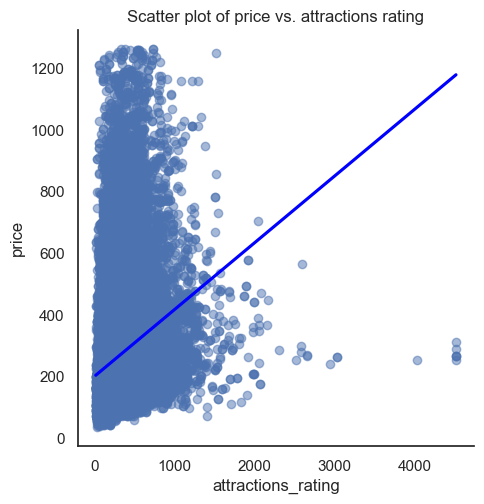

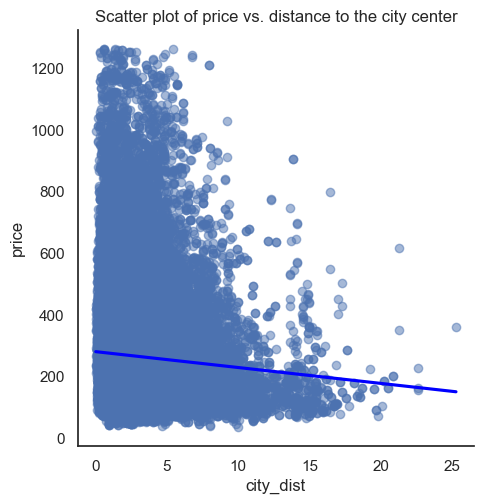

In [31]:
# Create scatter plot of price vs. number of bedrooms
sns.lmplot(x='attractions_rating', y='price', data=df,
           line_kws={'color': 'blue'}, ci=None, scatter_kws={'alpha':0.5})
plt.title('Scatter plot of price vs. attractions rating')
plt.show()

# Create scatter plot of price vs. city distance
sns.lmplot(x='city_dist', y='price', data=df,
           line_kws={'color': 'blue'}, ci=None, scatter_kws={'alpha':0.5})
plt.title('Scatter plot of price vs. distance to the city center')
plt.show()

In [32]:
# Calculate the covariance between "price" and "number of bedrooms"
covariance = df['satisfaction_rating'].cov(df['city_dist'])

# Calculate the Pearson's correlation coefficient between "price" and "number of bedrooms"
corr_coeff = df['satisfaction_rating'].corr(df['city_dist'])

print('Covariance:', covariance)
print('Pearson\'s correlation coefficient:', corr_coeff)

Covariance: -0.06272180949299948
Pearson's correlation coefficient: -0.0029292474928485183


In [33]:
"""
11. Conduct a test on your hypothesis using one of the methods
"""

'\n11. Conduct a test on your hypothesis using one of the methods\n'

In [34]:
"""
null hypothesis:  listings with different room types have the same mean price.
alternative hypothesis:  listings with room type of private room have a higher mean price than listings with room type of shared room.
"""

'\nnull hypothesis:  listings with different room types have the same mean price.\nalternative hypothesis:  listings with room type of private room have a higher mean price than listings with room type of shared room.\n'

In [35]:
class MeanPriceDiffTest(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(np.mean(group1) - np.mean(group2))
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [36]:
# create two groups to compare
group1 = df[df['room_type_Private room'] == 1]['price']
group2 = df[df['room_type_Private room'] == 0]['price']

# run the hypothesis test
ht = MeanPriceDiffTest((group1, group2))

# p-value
pvalue = ht.PValue()

# t-statistic

In [37]:
"""
12. For this project, conduct a regression analysis on either one dependent and one explanatory variable, or multiple explanatory variables
"""

'\n12. For this project, conduct a regression analysis on either one dependent and one explanatory variable, or multiple explanatory variables\n'

In [38]:
def regression_analysis(X, y, model, degree):
    # Get the polynomial features of the explanatory variables
    X = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(X)

    # fit the model to the data
    model.fit(X, y)

    # print the R^2 value
    print('R^2: ', r2_score(y, model.predict(X)))
    print('MSE: ', mean_squared_error(y, model.predict(X)))

In [39]:
# Choose the dependent variable
y = df['price']

# Choose the explanatory variables
X = df.drop('price', axis=1)

# Create a linear regression model
reg_1def = regression_analysis(X, y, LinearRegression(), 1)
reg_1def

R^2:  0.31397262287996663
MSE:  21212.814345769344


In [40]:
# 2 Degree Polynomial Regression
reg_2def = regression_analysis(X, y, LinearRegression(), 2)
reg_2def

R^2:  0.4683977959417479
MSE:  16437.797144233224


In [41]:
# 3 Degree Polynomial Regression
reg_3def = regression_analysis(X, y, LinearRegression(), 3)
reg_3def

R^2:  0.5203456046639672
MSE:  14831.506697458286


In [42]:
# 4 Degree Polynomial Regression
reg_4def = regression_analysis(X, y, LinearRegression(), 4)
reg_4def

R^2:  0.5446012392803745
MSE:  14081.492498146474


In [43]:
import statsmodels.api as sm

# Use statsmodels to get p-values
X_poly_sm = sm.add_constant(X)
model = sm.OLS(y, X_poly_sm)
results = model.fit()
p_values = results.pvalues[1:]

# sort the p-values from lowest to highest
p_values.sort_values(ascending=True)

bedrooms                  0.000000e+00
attractions_rating        0.000000e+00
lng-lat                   0.000000e+00
room_type_Private room    0.000000e+00
room_type_Shared room     1.548925e-90
city_dist                 5.591968e-31
host_is_superhost_True    1.458191e-22
satisfaction_rating       6.486979e-08
2_4_listings_host         1.033612e-06
4_plus_listings host      2.406498e-04
cleanliness_rating        5.416517e-01
dtype: float64